In [1]:
import copy

import gym
from gym_minigrid.minigrid import Grid
from gym_minigrid.wrappers import FullyObsWrapper, ReseedWrapper, RGBImgObsWrapper
import matplotlib.pylab as plt
import numpy as np
import pickle
from PIL import Image
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import torch

from rlpyt.envs.gym import make as gym_make
from rlpyt.models.dqn.grid_dsr_model import GridDsrModel, GridDsrSmallModel, GridDsrCompactModel, GridDsrRandomModel
from rlpyt.utils.seed import set_seed

In [2]:
def print_param_sumstats(params, name):
    print('Summary stats for {}'.format(name))
    param = params[name]
    print('Sum: {}'.format(param.sum()))
    print('Mean: {}'.format(param.mean()))
    print('Std: {}'.format(param.std()))
    print('Max: {} Min: {}'.format(param.max(), param.min()))
    print()

### Setup

In [129]:
env_id = 'MiniGrid-FourRooms-v0'
mode = 'random'
minigrid_config = {'mode': mode}
set_seed(333)

using seed 333


### Environment Testing

In [130]:
env = gym_make(id=env_id, minigrid_config=minigrid_config)
env.reset()
print(env.agent_pos)

[6 4]


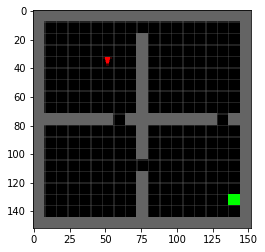

In [131]:
plt.imshow(env.env.env.step(0)[0]['image'])

In [4]:
features = env.feature_map

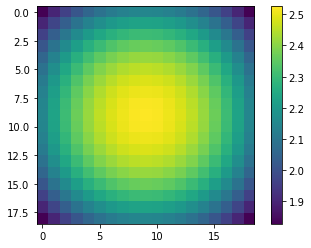

In [5]:
plt.imshow(np.linalg.norm(features, axis=2))
plt.colorbar()

In [10]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [19]:
def generate_block():
    x = np.ones((19, 19, 3))
    x[:, :, 0:3] = np.random.uniform(0, 1, (3,))
    plt.imshow(x)
    plt.figure() 

    y = np.ones((19, 19, 3))
    y[:,:,0:3] = np.random.uniform(0, 1, (3,))
    plt.imshow(y)

    plt.figure()
#     c = c.reshape(50, 50)[:, :, None]
    a = np.array([[(x, y) for x in range(19)] for y in range(19)])
    c = np.linalg.norm(a - np.array([0, 0]).reshape(1, 1, 2), axis=2)[:, :, None]
    c = normalize(c)
    gradient = x + (y - x) * c
    plt.imshow(gradient)
    return x, y, gradient

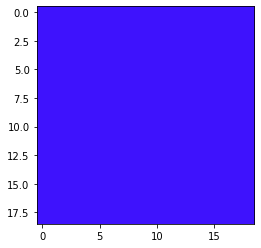

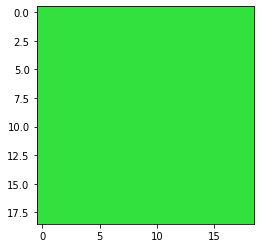

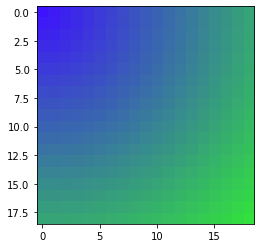

In [20]:
_, _, features = generate_block()

In [23]:
features[(3, 3)]

array([0.23699686, 0.20667275, 0.87051082])

In [94]:
env = gym_make(id=env_id, minigrid_config=minigrid_config)
o = env.reset()
plt.imshow(o.transpose(1, 0, 2))

ValueError: axes don't match array

In [9]:
cpu_device = torch.device('cpu')

In [10]:
def load_model(param_file, mode='full'):
    params = torch.load(param_file, map_location=cpu_device)
    if mode == 'full':
        model = GridDsrModel(env.observation_space.shape, env.action_space.n)
    elif mode == 'small':
        model = GridDsrSmallModel(env.observation_space.shape, 4)
    elif mode == 'compact':
        model = GridDsrCompactModel(env.observation_space.shape, env.action_space.n)
    model_params = params['agent_state_dict']['model']
    model.load_state_dict(model_params)
    return model

### Test Reconstruction

In [11]:
def get_obs(cur_env, n):
    obs_arr = [cur_env.reset()]
    for _ in range(n):
        obs, _, _, _ = cur_env.step(cur_env.action_space.sample())
        obs_arr.append(obs)
    obs_imgs = [Image.fromarray(obs, 'RGB') for obs in obs_arr]
    return obs_arr, obs_imgs

In [12]:
def get_reconstruction(model, obs_arr):
    obs_in = []
    re_arr = []
    re_imgs = []
    for obs in obs_arr:
        obs = torch.Tensor(obs).type(torch.float).unsqueeze(0) / 255
        obs_in.append(obs.squeeze(0).data.numpy())
        re = model(obs, mode='reconstruct')
        re = re.squeeze(0).data.numpy()
        re_arr.append(copy.copy(re))
        re[re < 0] = 0
        re *= 255
#         re = np.interp(re, (re.min(), re.max()), (0, 255))
        re = re.astype('uint8')
        re_imgs.append(Image.fromarray(re, 'RGB'))
    return re_arr, re_imgs, obs_in

In [13]:
def get_features(model, obs_arr):
    features = []
    for obs in obs_arr:
        obs = torch.Tensor(obs).unsqueeze(0)
        features.append(model(obs))
    return features

In [366]:
model = load_model('../experiments/trained-models/20191119-run4.pkl', mode=mode)

In [367]:
obs, obs_imgs = get_obs(env, 100)
re, re_imgs, obs_in = get_reconstruction(model, obs)
features = get_features(model, obs)

In [368]:
idx = 0

In [88]:
obs_imgs[idx]

NameError: name 'obs_imgs' is not defined

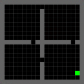

In [370]:
re_imgs[idx]

In [371]:
pos = []
for r, row in enumerate(obs[0]):
    for c, col in enumerate(row):
        if col[0] > 235:
            pos.append((r, c))

In [372]:
for p in pos:
    print('Position:', p)
    print('Target:', obs_in[0][p])
    print('Reconstructed:', re[0][p])
    print()

Position: (28, 55)
Target: [0.9647059 0.        0.       ]
Reconstructed: [ 0.03035818 -0.00097075  0.00204869]

Position: (28, 56)
Target: [0.96862745 0.         0.        ]
Reconstructed: [0.01639211 0.00097826 0.0007984 ]

Position: (29, 56)
Target: [0.93333334 0.         0.        ]
Reconstructed: [ 0.01482491  0.0019493  -0.00057513]



### Visualize DSR

In [8]:
def generate_dsr_grid(DSR, starting_pos=(12, 6)):
    starting_sf = DSR[starting_pos]
    grid = np.zeros((19, 19))
    for i in range(19):
        for j in range(19):
            val = -1e-1
            pos = (i, j)
            if pos in DSR:
                val = torch.norm(DSR[pos] - starting_sf, 2)
            grid[i, j] = val
    return grid.T

In [15]:
def visualize_dsr(successor_file, starting_pos=(12, 6)):
    with open(successor_file, 'rb') as handle:
        DSR = pickle.load(handle)
    grid = generate_dsr_grid(DSR, starting_pos)
#     f, ax = plt.subplots(figsize=(17, 17))
#     heatmap = sns.heatmap(grid, annot=True, linewidth=0.5)
    return heatmap, grid

In [16]:
def get_dsr_norm(successor_file):
    with open(successor_file, 'rb') as handle:
        DSR = pickle.load(handle)
    grid = np.zeros((19, 19))
    for i in range(19):
        for j in range(19):
            val = np.nan
            pos = (i, j)
            if pos in DSR:
                val = torch.norm(DSR[pos], 2)
            grid[i, j] = val
    
    mean = np.nanmean(grid)
    grid[np.isnan(grid)] = mean
    return grid.T

### New Fixed Random Feature Representation, Gaussian Feature Representation

In [142]:
heatmap, dsr_gaussian = visualize_dsr('../experiments/successor-data/20200202-run7.pkl', (6, 4))

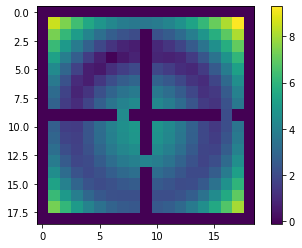

In [143]:
plt.imshow(dsr_gaussian)
plt.colorbar()

In [45]:
dsr_gaussian[(6, 15)]

tensor([[10.6589, 12.8472, 13.0828, 12.3626, 12.9048, 11.8756, 13.1237, 12.3923,
         13.9515,  7.3510, 12.5988, 10.2271, 16.3833, 14.6081, 15.0797, 13.1660]],
       requires_grad=True)

In [49]:
dsr_gaussian[(6, 16)]

tensor([[ 9.5028, 11.3394, 11.6921, 11.1495, 11.6314, 10.4884, 11.8472, 11.1912,
         12.3191,  6.4462, 11.1995,  9.2268, 14.5931, 13.0528, 13.4508, 12.0180]],
       requires_grad=True)

In [46]:
dsr_gaussian[(7, 16)]

tensor([[ 9.6673, 11.9316, 11.8619, 11.4744, 12.0456, 10.6351, 12.1680, 11.7454,
         12.8012,  6.7963, 11.7059,  9.6073, 15.1095, 13.5570, 13.9523, 12.4330]],
       requires_grad=True)

In [40]:
dsr_gaussian_norms = get_dsr_norm('../experiments/successor-data/20200129-run1.pkl')

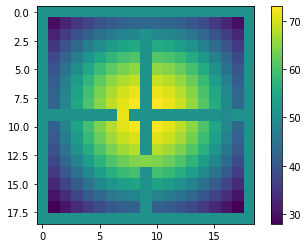

In [41]:
plt.imshow(dsr_gaussian_norms)
plt.colorbar()

### Old DSR Attempts

In [108]:
dsr_onehot[(9, 1)][]

tensor(0.4743, grad_fn=<SelectBackward>)

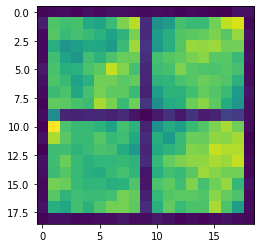

In [8]:
plt.imshow(dsr_onehot[(9, 1)].reshape(19, 19).detach())

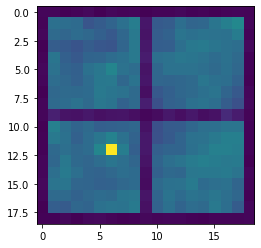

In [7]:
plt.imshow(dsr_onehot[(12, 6)].detach().reshape(19, 19))

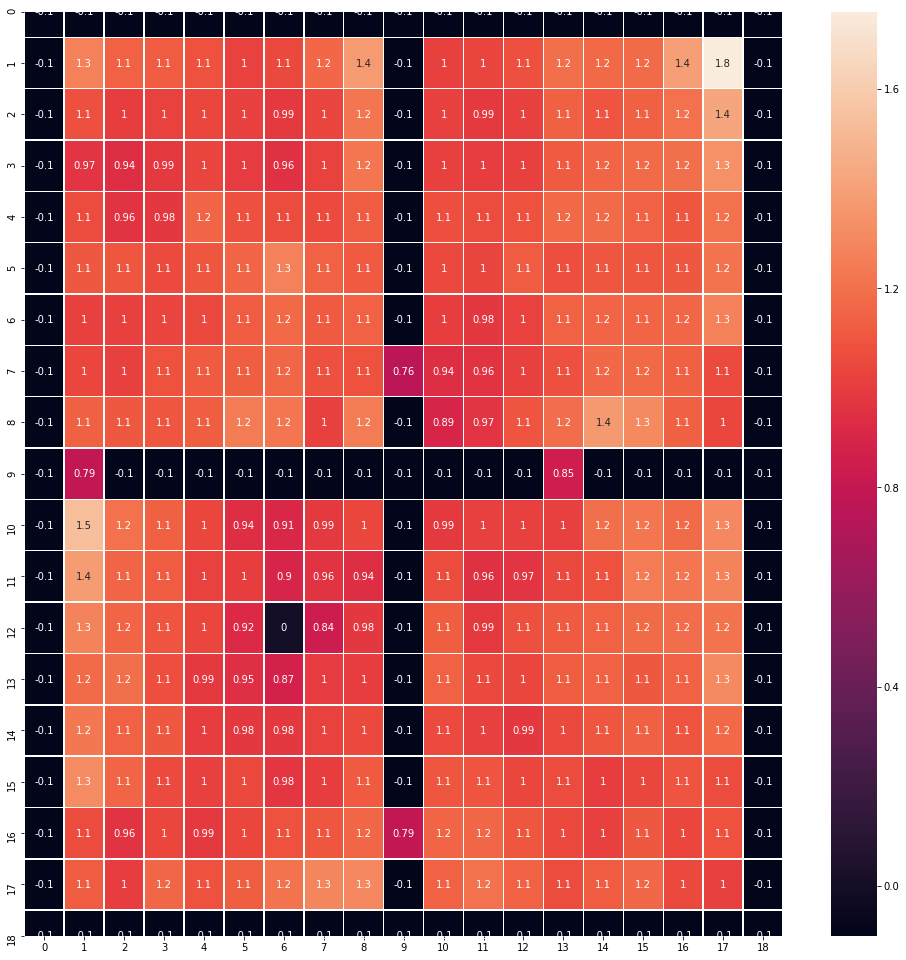

In [6]:
heatmap, dsr_onehot = visualize_dsr('../experiments/successor-data/20200114-run2.pkl', (12, 6))
heatmap

Discount rate of 0.0001

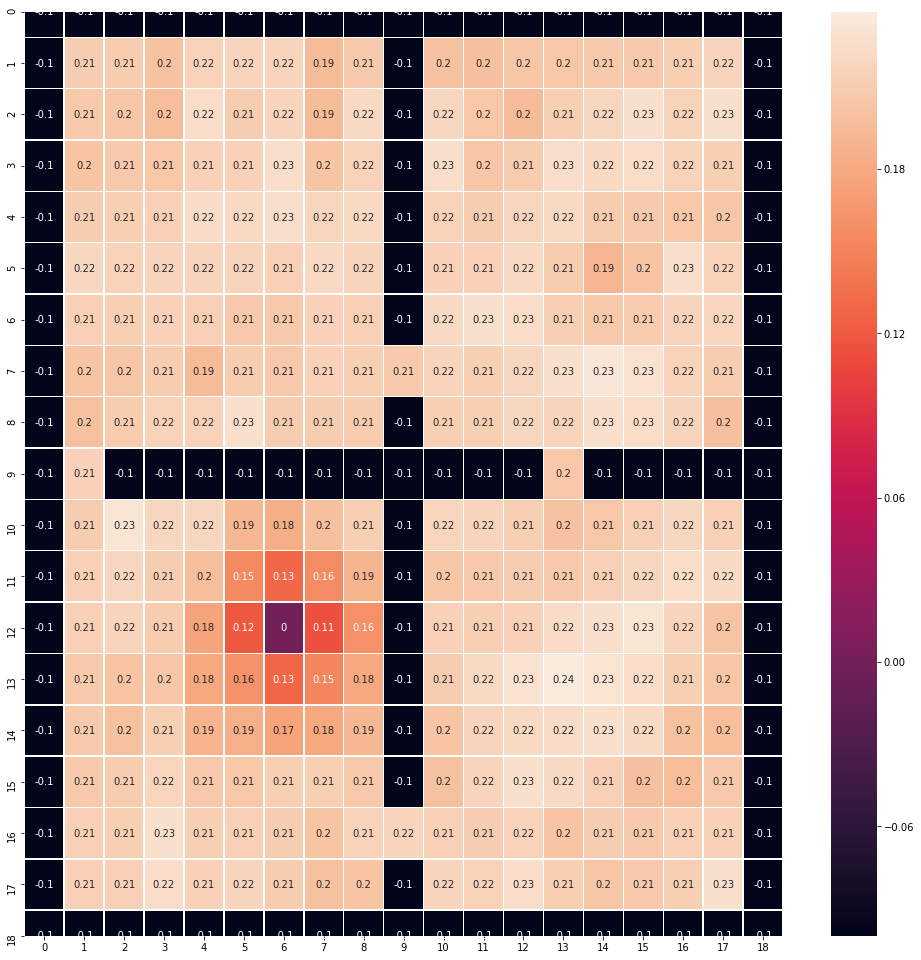

In [250]:
heatmap, dsr_tiny_discount = visualize_dsr('../experiments/successor-data/20191119-run3.pkl', (12, 6))
heatmap

5 x 5 locality

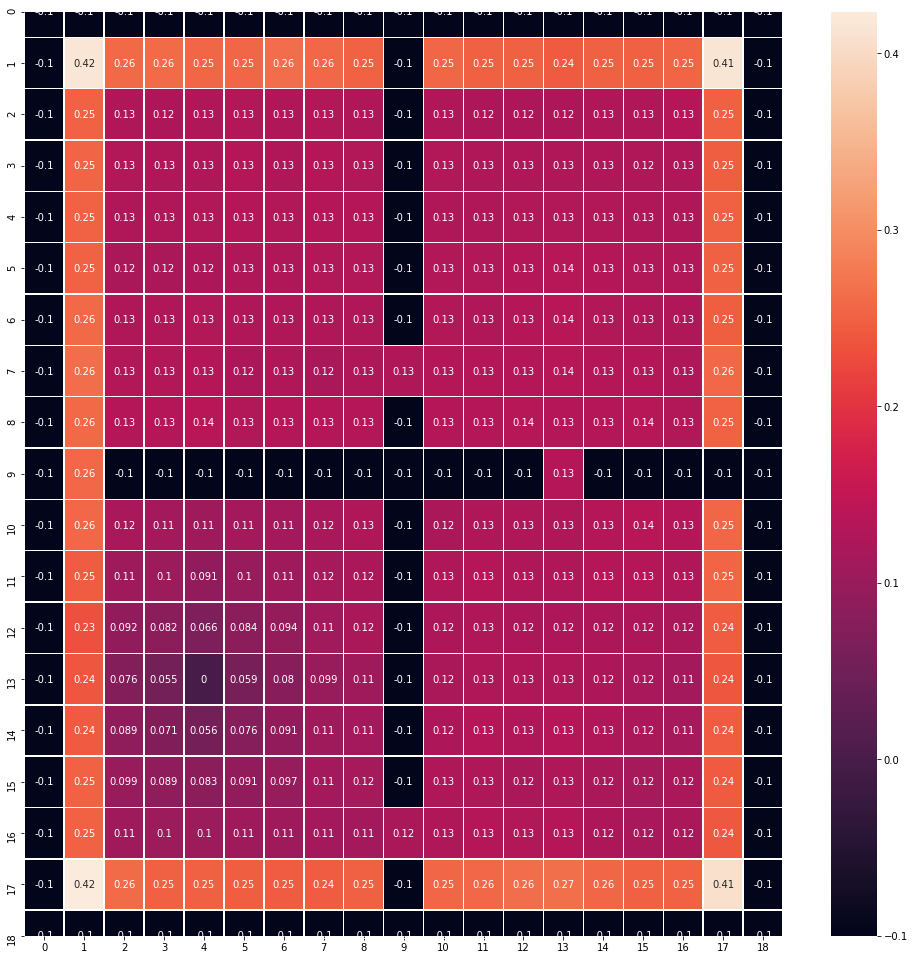

In [251]:
heatmap, dsr_tiny_discount_5x5 = visualize_dsr('../experiments/successor-data/20191201-run0.pkl',(12, 6))
heatmap

1 x 1 locality

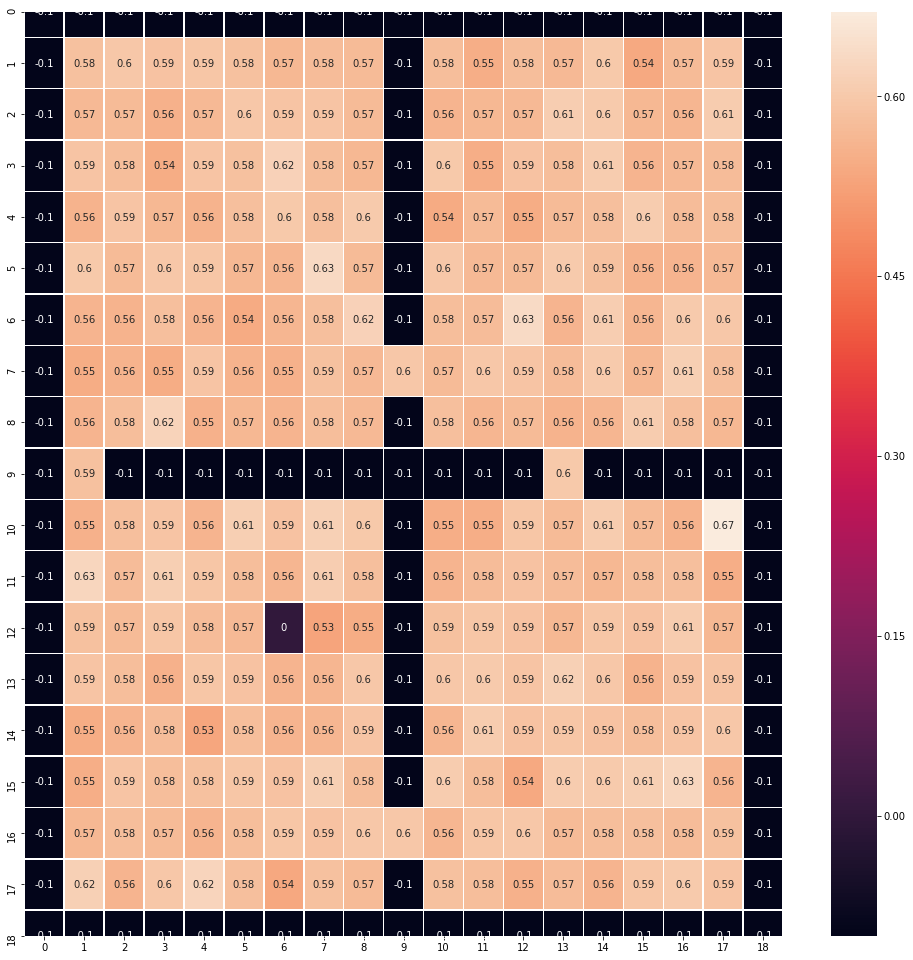

In [256]:
heatmap, dsr_tiny_discount_1x1 = visualize_dsr('../experiments/successor-data/20191201-run1.pkl',(12, 6))
heatmap

Discount rate of 0.1

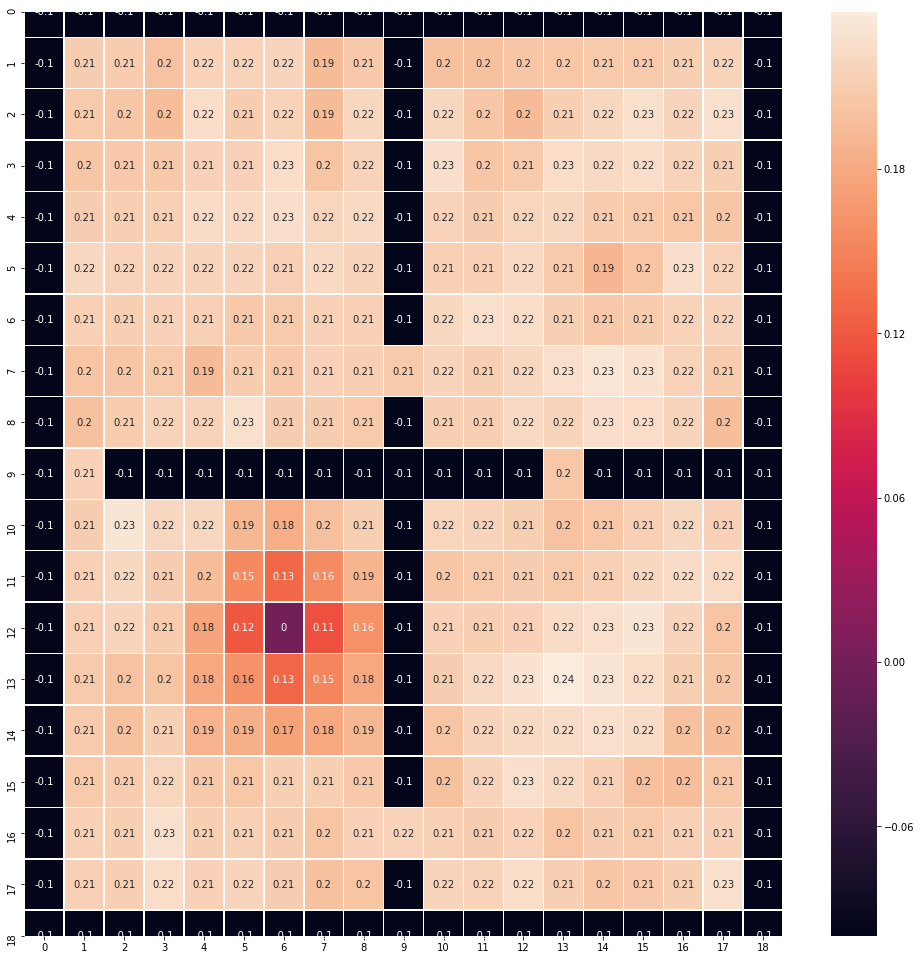

In [255]:
heatmap, dsr_smaller_discount = visualize_dsr('../experiments/successor-data/20191118-run1.pkl', (12, 6))
heatmap

Discount rate of 0.90

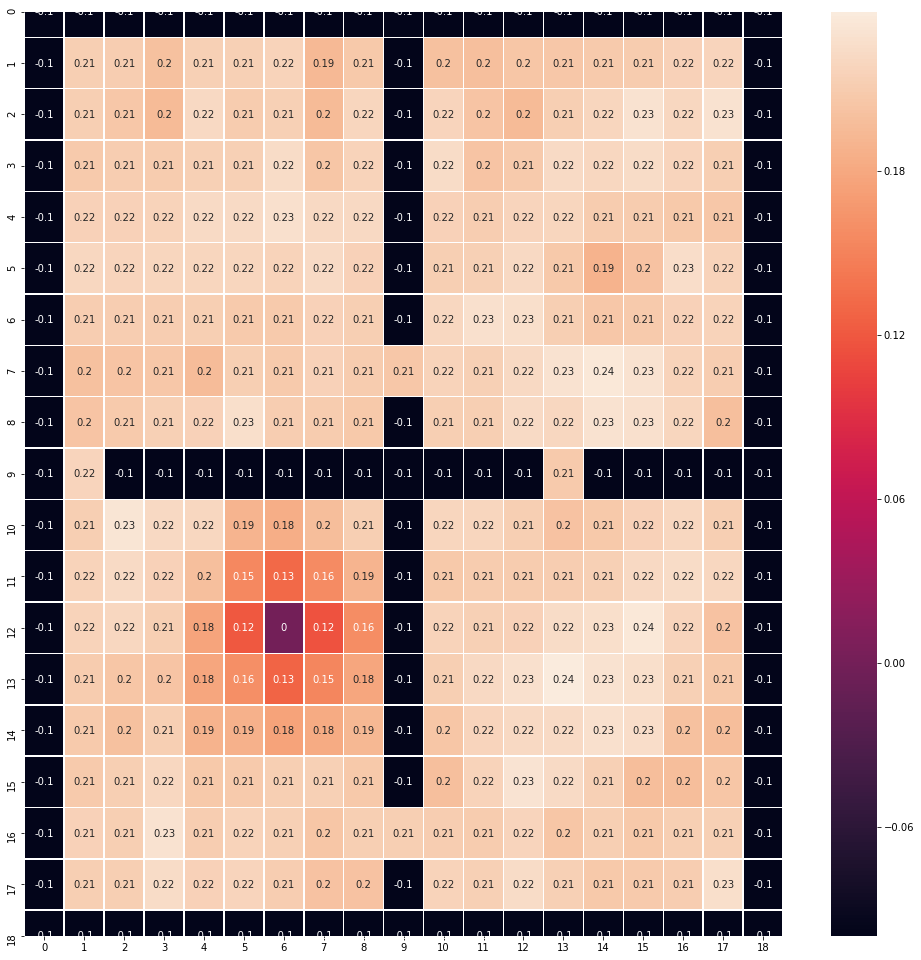

In [257]:
heatmap, dsr_small_discount = visualize_dsr('../experiments/successor-data/20191115-run0-20k.pkl', (12, 6))
heatmap

Discount rate of 0.99, 3x3 locality

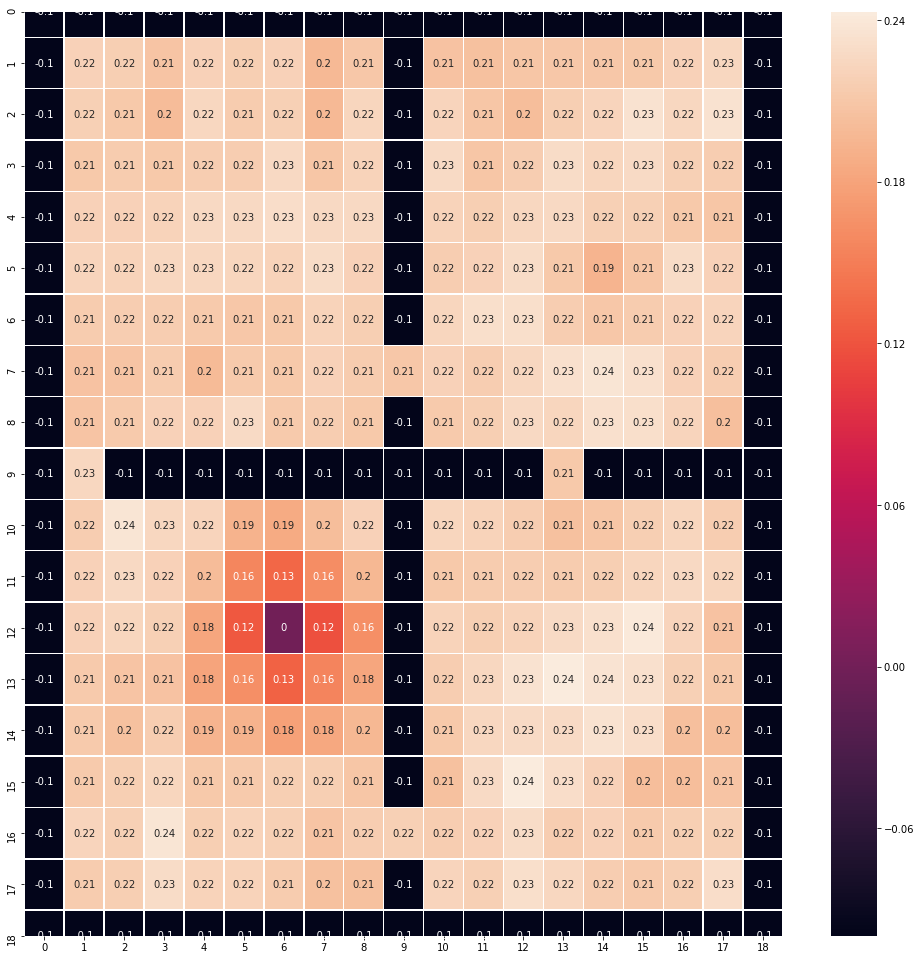

In [258]:
heatmap, dsr_3x3 = visualize_dsr('../experiments/successor-data/20191109-run4-20k.pkl', (12, 6))
heatmap

No training, 3x3 locality

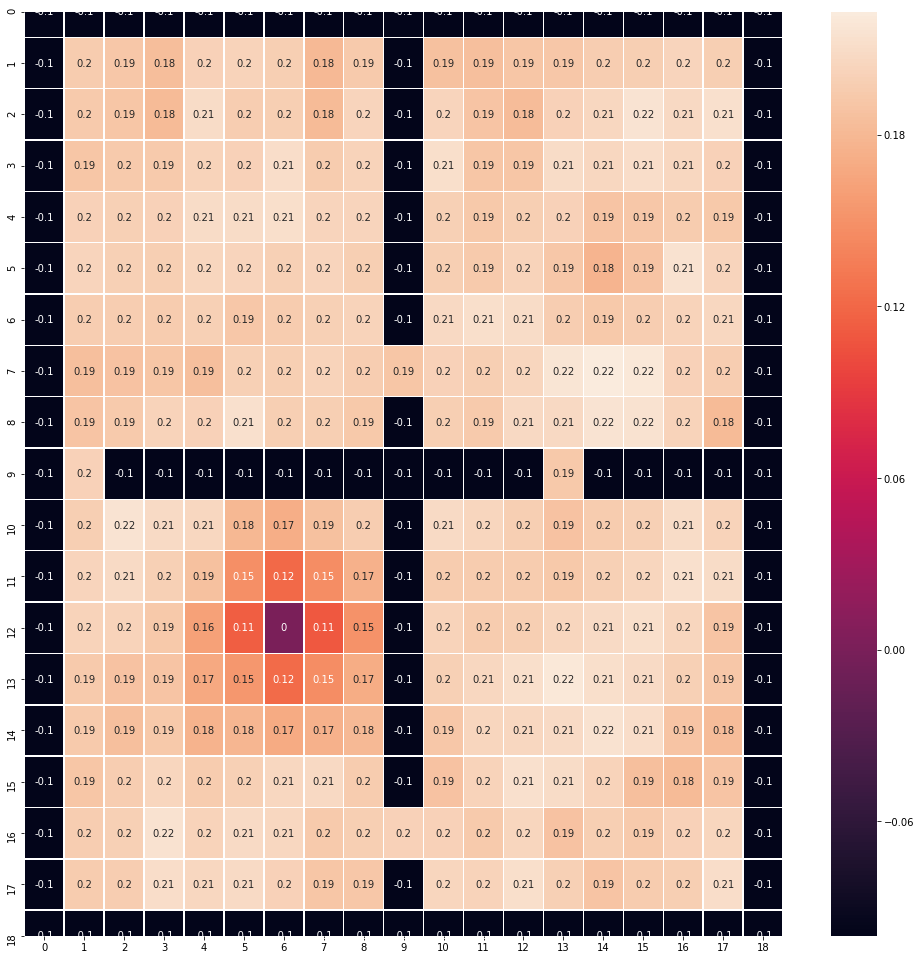

In [259]:
heatmap, dsr_no_train_3x3 = visualize_dsr('../experiments/successor-data/20191109-run4-init.pkl', (12, 6))
heatmap

In [260]:
abs(dsr_3x3[(12, 6)] - dsr_no_train_3x3[(12, 6)])

tensor([0.0559, 0.0531, 0.0622,  ..., 0.0735, 0.0260, 0.0723],
       grad_fn=<AbsBackward>)

Discount rate of 0.99, using random starting positions during training

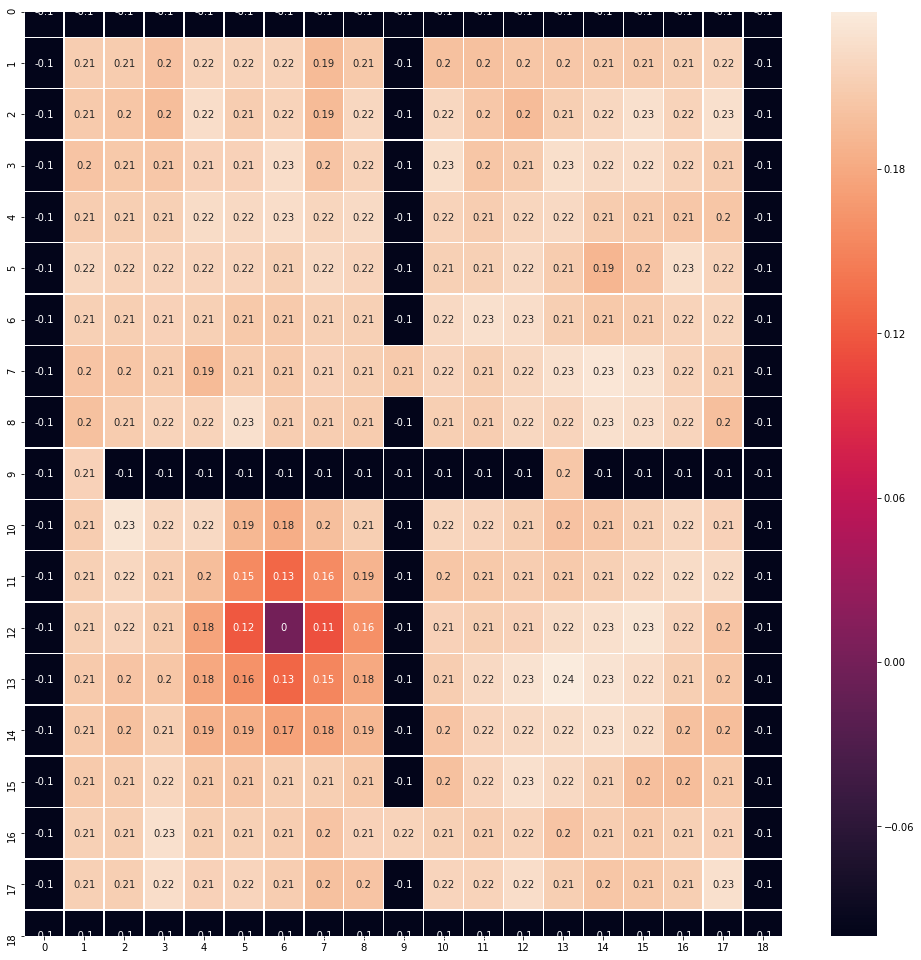

In [261]:
heatmap, dsr_random_3x3 = visualize_dsr('../experiments/successor-data/20191126-run0.pkl', (12, 6))
heatmap

Discount rate of 0.999

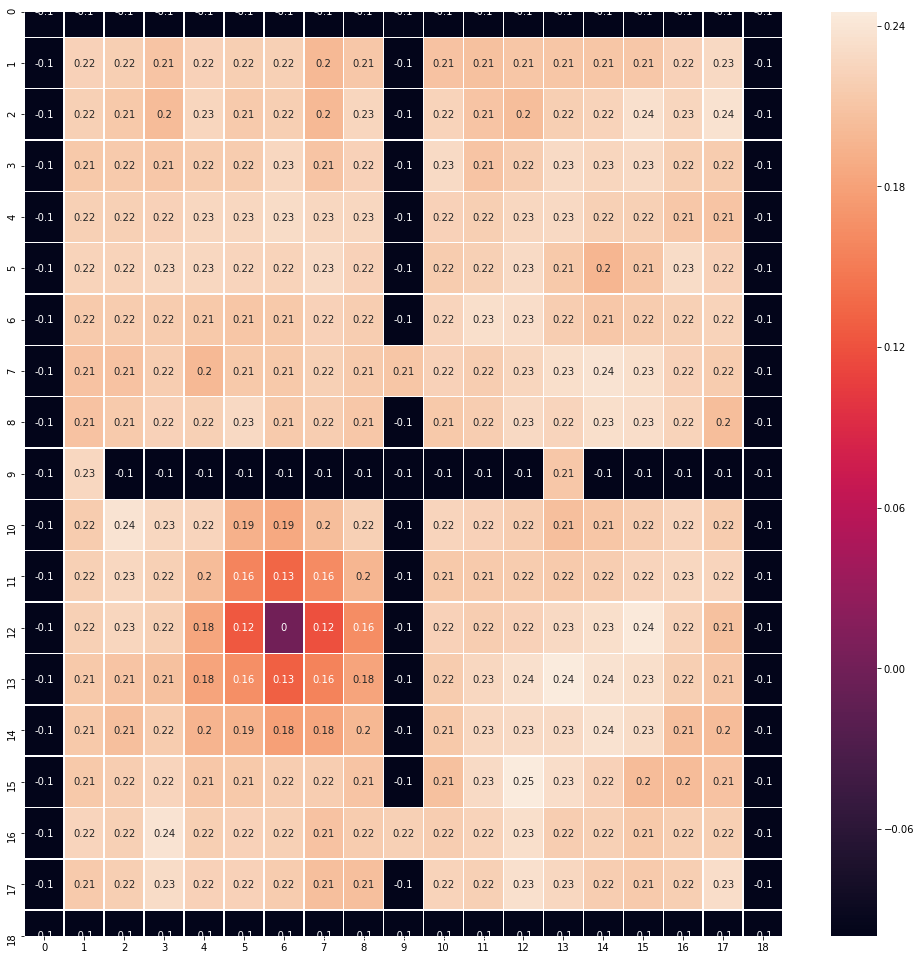

In [263]:
heatmap, dsr_large_discount = visualize_dsr('../experiments/successor-data/20191115-run1-20k.pkl', (12, 6))
heatmap

Agent position encoded as one-hot feature vector (length 361)

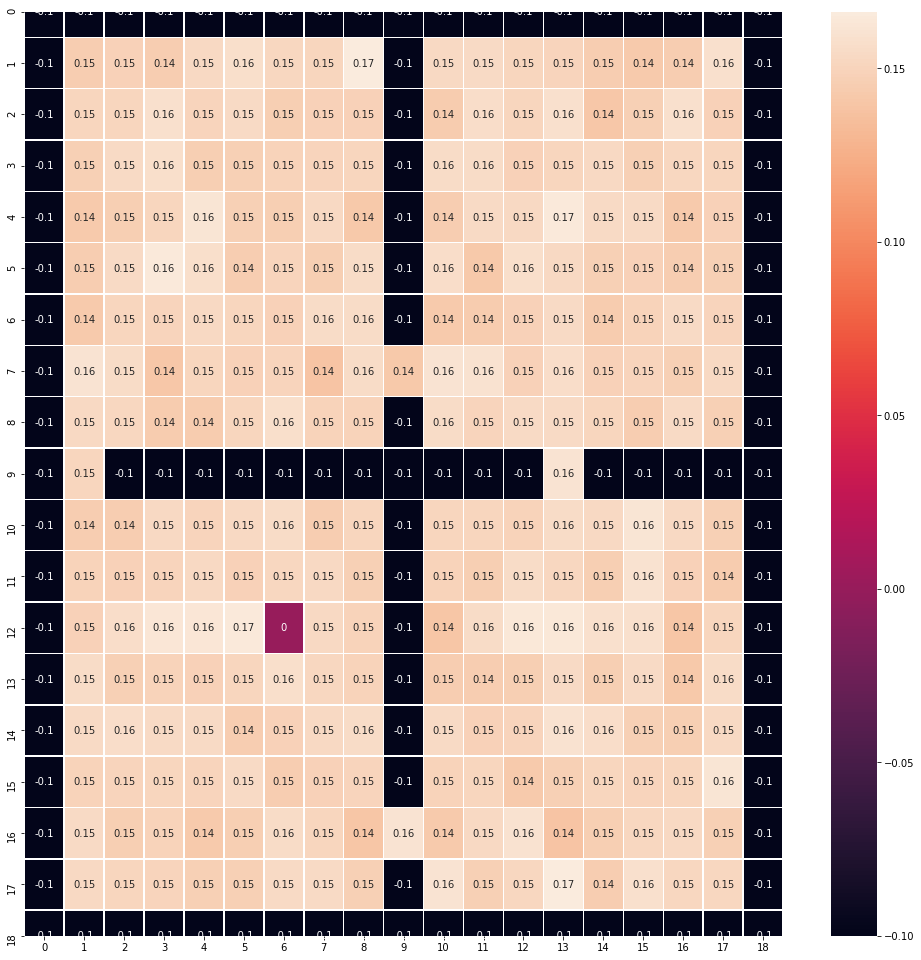

In [7]:
grid, DSR_pos = generate_dsr_grid('../experiments/successor-data/20191202-run0.pkl', (12, 6))
f, ax = plt.subplots(figsize=(17, 17))
sns.heatmap(grid, annot=True, linewidth=0.5)

Apply PCA to DSR

(array([ 2.,  8., 22., 46., 77., 79., 71., 34., 16.,  6.]),
 array([-0.031818  , -0.02578327, -0.01974854, -0.01371382, -0.00767909,
        -0.00164436,  0.00439036,  0.01042509,  0.01645982,  0.02249454,
         0.02852927], dtype=float32),
 <a list of 10 Patch objects>)

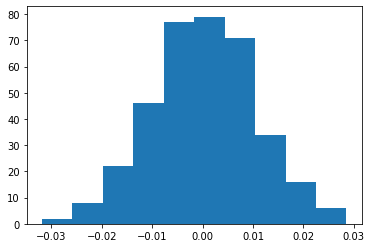

In [268]:
plt.hist(DSR_pos[(12, 6)].detach().numpy())

(array([ 7.,  8., 26., 46., 89., 78., 58., 32., 14.,  3.]),
 array([-0.02907862, -0.02331969, -0.01756075, -0.01180181, -0.00604288,
        -0.00028394,  0.00547499,  0.01123393,  0.01699287,  0.0227518 ,
         0.02851074], dtype=float32),
 <a list of 10 Patch objects>)

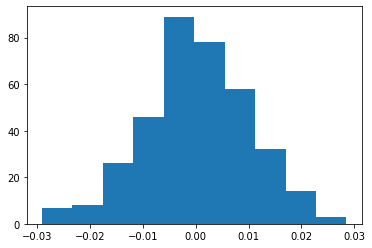

In [269]:
plt.hist(DSR_pos[(12, 5)].detach().numpy())

In [186]:
features = np.stack([DSR_pos[key].detach().numpy() for key in sorted(DSR_pos.keys())], axis=1).T

In [206]:
features.shape

(260, 361)

In [209]:
pca = PCA(n_components=50)

In [211]:
reduced = pca.fit_transform(features)
print(reduced.shape)
print(pca.explained_variance_ratio_)

(260, 50)
[0.01568102 0.01515637 0.01429916 0.01414545 0.01393938 0.01356406
 0.01313591 0.01285696 0.01274949 0.01264461 0.0124731  0.01210458
 0.01197935 0.01188935 0.01143426 0.01123001 0.01107424 0.0109583
 0.01082095 0.01065057 0.01048829 0.0102308  0.01006789 0.00993881
 0.00977386 0.00966217 0.00957761 0.0094027  0.00937576 0.00934956
 0.00920199 0.00905011 0.00884882 0.00881197 0.00865441 0.00852764
 0.00845436 0.00831978 0.00818581 0.00811778 0.00805419 0.00789373
 0.00784376 0.00772146 0.00764441 0.00757488 0.00740491 0.00732452
 0.00726599 0.00723957]


In [235]:
DSR_pos_reduced = {}
for i, key in enumerate(sorted(DSR_pos.keys())):
    DSR_pos_reduced[key] = reduced[i]

In [214]:
starting_sf = DSR_pos_reduced[(12, 6)]
grid = np.zeros((19, 19))
for i in range(19):
    for j in range(19):
        val = -1e-1
        pos = (i, j)
        if pos in DSR_pos_reduced:
            val = np.linalg.norm(DSR_pos_reduced[pos] - starting_sf, 2)
        grid[i, j] = val
f, ax = plt.subplots(figsize=(17, 17))
sns.heatmap(grid, annot=True, linewidth=0.5)

Agent position given directly as (x, y) coordinates

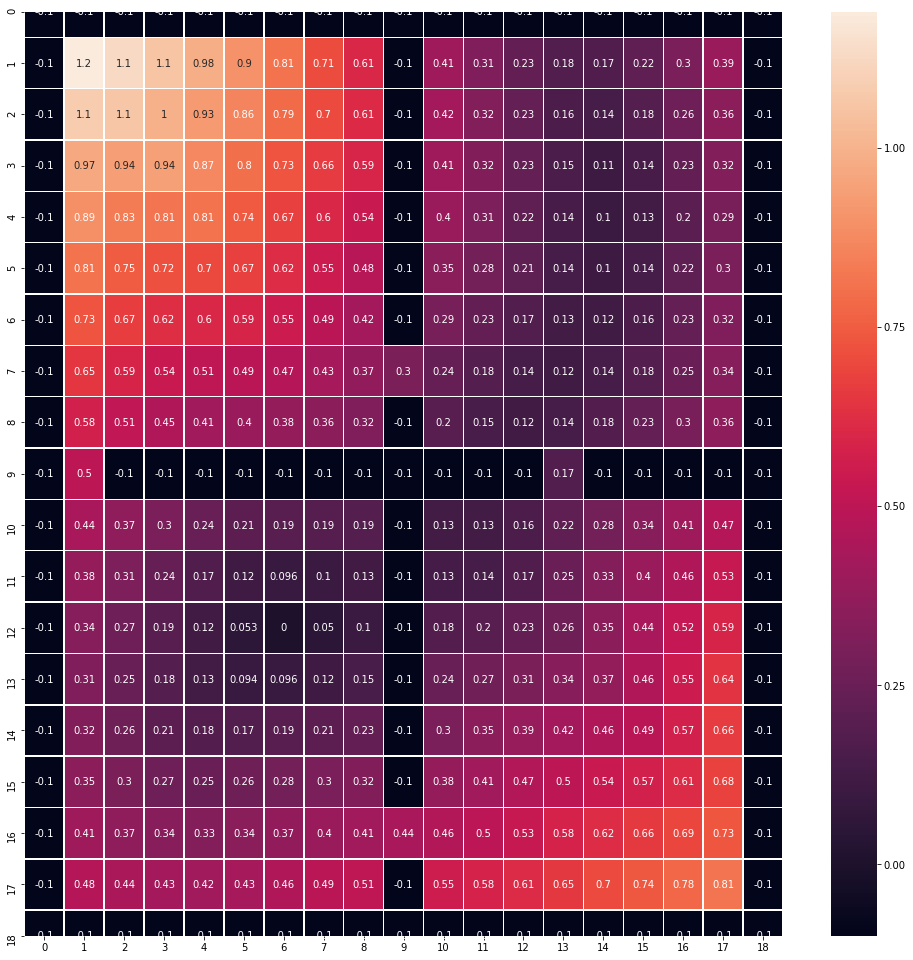

In [271]:
heatmap, DSR_pos_40k = visualize_dsr('../experiments/successor-data/20191202-run1.pkl', (12, 6))
heatmap

Agent position given directly as (x, y) coordinates, no training done

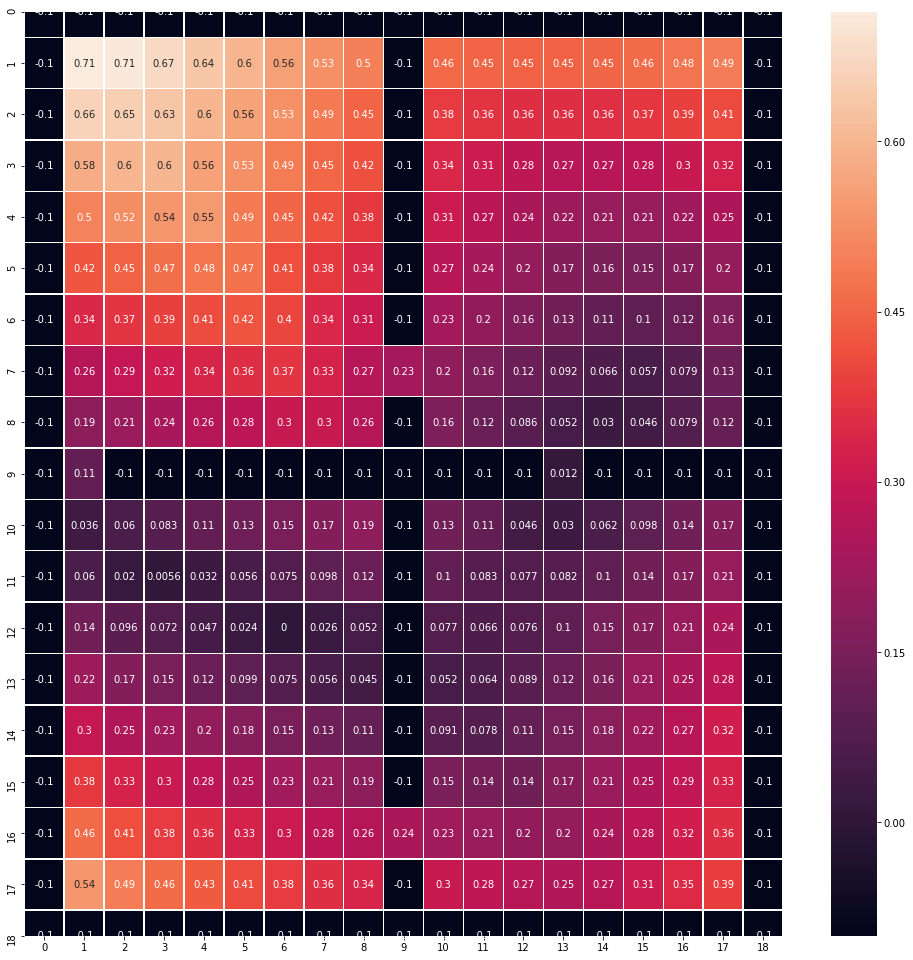

In [272]:
heatmap, DSR_no_train_pos = visualize_dsr('../experiments/successor-data/20191202-run1-init.pkl', (12, 6))
heatmap

In [351]:
y_line = []
x_line = []
for key, val in DSR_pos1.items():
    y_line.append((key[0], val[0], val[1]))
    x_line.append((key[1], val[0], val[1]))

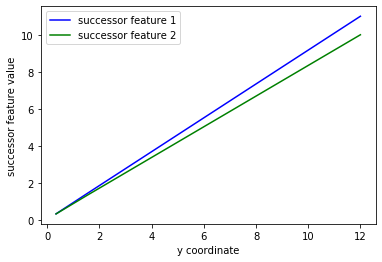

In [357]:
plt.plot(y_line[0], y_line[1], color='blue', label='successor feature 1')
plt.plot(y_line[0], y_line[2], color='green', label='successor feature 2')
plt.xlabel('y coordinate')
plt.ylabel('successor feature value')
plt.legend()

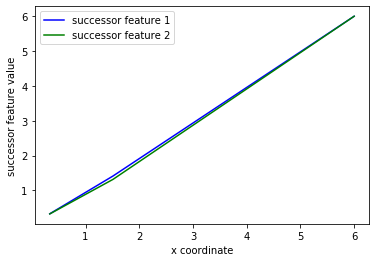

In [358]:
plt.plot(x_line[0], x_line[1], color='blue', label='successor feature 1')
plt.plot(x_line[0], x_line[2], color='green', label='successor feature 2')
plt.xlabel('x coordinate')
plt.ylabel('successor feature value')
plt.legend()

Trained for longer (100k iterations, 50k model used)

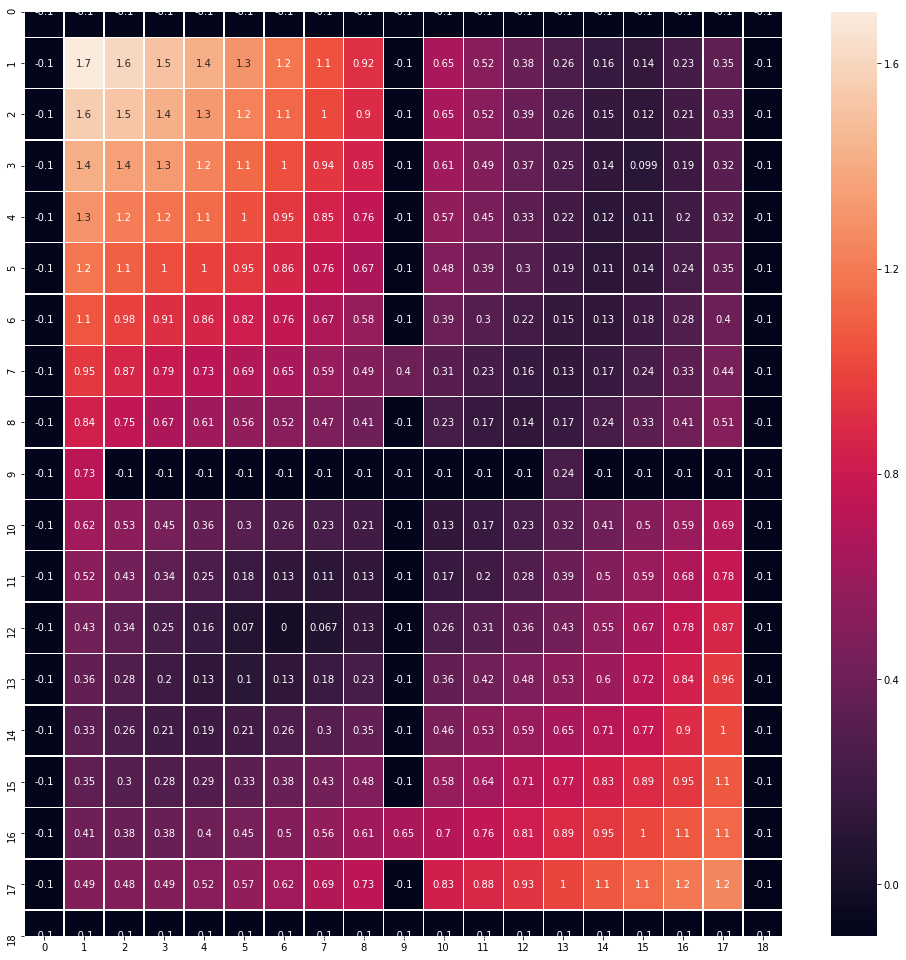

In [267]:
heatmap, DSR_pos_50k = visualize_dsr('../experiments/successor-data/20191202-run2.pkl', (12, 6))
heatmap

PCA applied to successor features (length 2)

In [218]:
features = torch.stack([DSR_pos2[key] for key in sorted(DSR_pos2.keys())], axis=1)

In [234]:
pca = PCA(n_components=1)
reduced = pca.fit_transform(features.T.detach().numpy())
pca.explained_variance_ratio_

array([0.96404517], dtype=float32)

In [239]:
DSR_pos_reduced = {}
for i, key in enumerate(sorted(DSR_pos2.keys())):
    DSR_pos_reduced[key] = reduced[i]

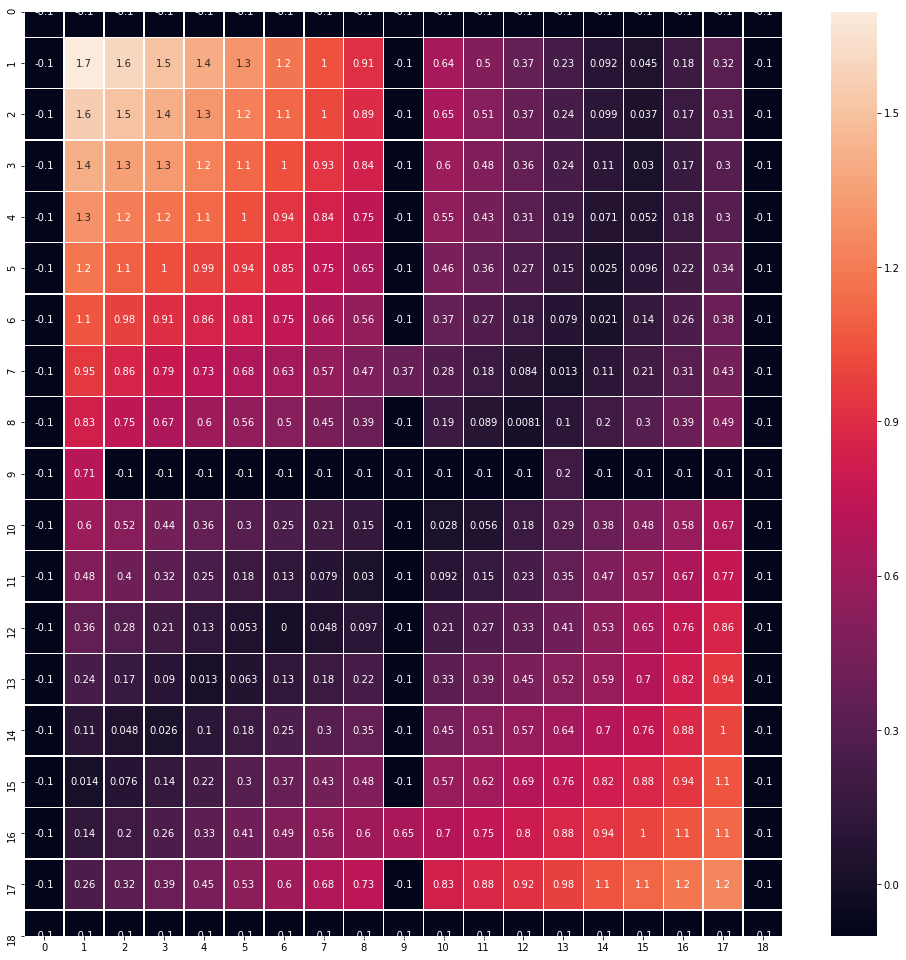

In [240]:
starting_sf = DSR_pos_reduced[(12, 6)]
grid = np.zeros((19, 19))
for i in range(19):
    for j in range(19):
        val = -1e-1
        pos = (i, j)
        if pos in DSR_pos_reduced:
            val = np.linalg.norm(DSR_pos_reduced[pos] - starting_sf, 2)
        grid[i, j] = val
f, ax = plt.subplots(figsize=(17, 17))
sns.heatmap(grid, annot=True, linewidth=0.5)

Normalized successor features (length 2)

In [219]:
features_norm = (features - features.mean(axis=1).view(-1, 1)) / features.std(axis=1).view(-1, 1)

In [220]:
DSR_pos_norm = {}

In [221]:
for i, key in enumerate(sorted(DSR_pos2.keys())):
    DSR_pos_norm[key] = features_norm[:, i]

In [223]:
starting_sf = DSR_pos_norm[(12, 6)]
grid = np.zeros((19, 19))
for i in range(19):
    for j in range(19):
        val = -1e-1
        pos = (i, j)
        if pos in DSR_pos_norm:
            val = torch.norm(DSR_pos_norm[pos] - starting_sf, 2)
        grid[i, j] = val

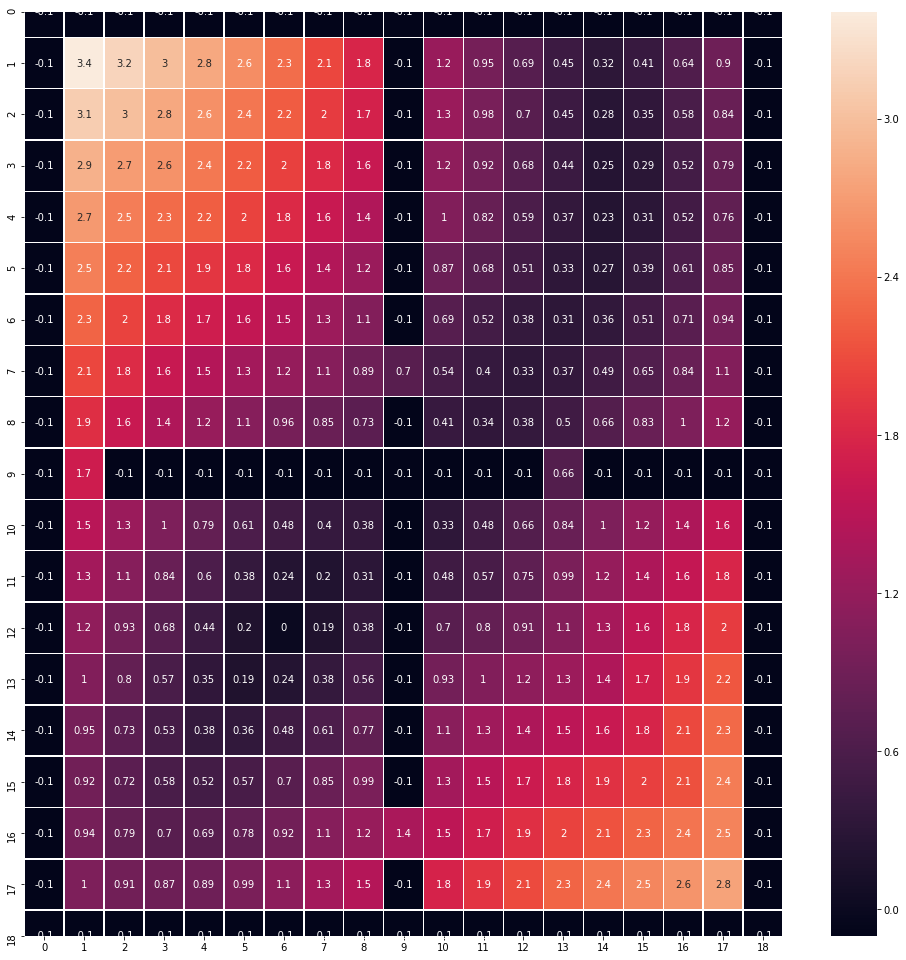

In [224]:
f, ax = plt.subplots(figsize=(17, 17))
sns.heatmap(grid, annot=True, linewidth=0.5)